### Demo for reading peaks and high-water marks and comparing them with max. water levels from model output.  

Fields in the .csv files are described here: https://my.usgs.gov/confluence/display/WSN/STN+Data+Dictionary+-+Top+Level
(but this will stop working on Jan 27, 2023, and a Sharepoint site will replace it)

This notebook demonstrates:
* Reading the `.csv` files for high-water marks and filtered peaks, picking out useful data, saving those as smaller `.csv` files, plotting the data, and finding the data closest to a target lat/lon
* Using `xroms` to read in model output
* Trimming the array to specified lat/lon boundaries
* Calculating max(zeta) across the time dimension
* Finding the closest model grid for each data point
* Making some ugly plots

csherwood@usgs.gov

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import xroms
import matplotlib.pyplot as plt

# These files were downloaded from https://stn.wim.usgs.gov/fev/ on 1/19/2023
data_dir = r'/vortexfs1/home/csherwood/proj/NOPP_Michael/data/'
hwm_file = 'Michael_FilteredHWMs.csv'
peaks_file = 'Michael_FilteredPeaks.csv'

# url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Michael2018/michael20/michael20.ncml'
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Michael2018/michael33/qck/michael_qck.ncml'


In [2]:
ds=xroms.open_netcdf(url)
ds

<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 12, s_w: 13, eta_rho: 702,
                      xi_rho: 1052, xi_u: 1051, eta_v: 701, ocean_time: 109)
Coordinates: (12/31)
  * s_rho            (s_rho) float64 -0.9583 -0.875 -0.7917 ... -0.125 -0.04167
  * s_w              (s_w) float64 -1.0 -0.9167 -0.8333 ... -0.1667 -0.08333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(702, 1052), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(702, 1052), meta=np.ndarray>
    lon_u            (eta_rho, xi_u) float64 dask.array<chunksize=(702, 1051), meta=np.ndarray>
    lat_u            (eta_rho, xi_u) float64 dask.array<chunksize=(702, 1051), meta=np.ndarray>
    ...               ...
    z_rho_v0         (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(12, 701, 1052), meta=np.ndarray>
    z_rho_psi0       (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(12, 701, 1051), meta=np.ndarray>
    z_w0             (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(13, 702, 1052), meta=np.ndarray>
    z_w_u0           (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(13, 702, 1051), meta=np.ndarray>
    z_w_v0           (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(13, 701, 1052), meta=np.ndarray>
    z_w_psi0         (s_w, eta_v, xi_u) float64 dask.array<chunksize=(13, 701, 1051), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/146)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    shuffle          int32 ...
    ...               ...
    dV_u             (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 12, 702, 1051), meta=np.ndarray>
    dV_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 13, 702, 1051), meta=np.ndarray>
    dV_v             (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 12, 701, 1052), meta=np.ndarray>
    dV_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 13, 701, 1052), meta=np.ndarray>
    dV_psi           (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 12, 701, 1051), meta=np.ndarray>
    dV_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 13, 701, 1051), meta=np.ndarray>
Attributes: (12/31)
    file:               michael_ocean_mexb_qck_00022.nc
    format:             netCDF-4/HDF5 file
    Conventions:        CF-1.4, SGRID-0.3
    type:               ROMS/TOMS quicksave file
    title:              GOMSAB Michael
    var_info:           ROMS/External/varinfo.dat
    ...                 ...
    compiler_flags:     -fc=ifort -ip -O3 -traceback -assume byterecl -I/vort...
    tiling:             012x007
    history:            ROMS/TOMS, Version 3.9, Monday - March 6, 2023 - 10:1...
    ana_file:           ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_c...
    CPP_options:        USEAST2_NOPP, ANA_BSFLUX, ANA_BTFLUX, ANA_CLOUD, ANA_...
    EXTRA_DIMENSION.N:  12

In [3]:
# want model output only within the box defined by these lat/lon values
lon = np.array([-86.5, -82.5])
lat = np.array([29.1, 30.3])
# this condition defines the region of interest
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

In [4]:
dss=ds.where(box, drop=True).zeta
dss

<xarray.DataArray 'zeta' (ocean_time: 109, eta_rho: 618, xi_rho: 1052)>
dask.array<where, shape=(109, 618, 1052), dtype=float32, chunksize=(1, 618, 1052), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 -86.21 -86.21 -86.21 ... -84.0 -84.0
    lat_rho     (eta_rho, xi_rho) float64 28.73 28.73 28.73 ... 31.21 31.21
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-07T12:00:00 ... 2018-10-12
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 ... 1046 1047 1048 1049 1050 1051
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 611 612 613 614 615 616 617
Attributes:
    long_name:    free-surface
    units:        meter
    time:         ocean_time
    grid:         <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cen...
    location:     face
    field:        free-surface, scalar, series
    _ChunkSizes:  [   1  702 1052]

/vortexfs1/home/csherwood/mambaforge/envs/NOPP/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


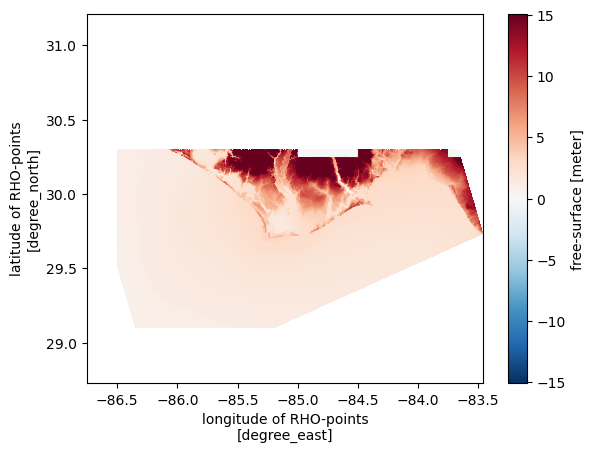

In [5]:
# find the maximum water level over the entire time
# adding the .compute() function was key to speeding up the lat/lon lookup below
zmax = dss.max(dim='ocean_time').compute()
ax = zmax.plot(x="lon_rho", y="lat_rho")

### Load the peaks data.
Examination reveals:  
* No time or stage estimates were made
* vdatum = NAVD88
* height_above_gnd is all NaNs
* all times are UTC

In [6]:
df = pd.read_csv(data_dir + peaks_file)
# make a copy of the dataframe with the stuff we want in it.
df_peaks = df[['latitude_dd','longitude_dd','peak_date']].copy()
df_peaks['peak_stage_m'] = df['peak_stage'].values*0.3048
df_peaks.describe()

,latitude_dd,longitude_dd,peak_stage_m
count,30.000000,30.000000,30.000000
mean,29.654684,-84.091079,2.112366
std,0.662729,1.156766,0.771363
min,26.654850,-86.584390,0.548640
25%,29.460884,-84.927692,1.648968
50%,29.724979,-83.632665,2.145792
75%,29.969995,-83.313137,2.514600
max,30.443430,-81.871830,4.739640


### Read the high-water mark file
Examination reveals:  
    * All vdatum are NAVD88

Values for `hwm_type_id`
```
HWM type code.  Current possibilities:
1 Mud
2 Debris
3 Clear water
4 Vegetation line
5 Seed line
6 Stain line
7 Melted snow line
8 Present at peak (direct observation)
9 Other (Note in Description box)
```
Values for `hwm_quality_id`
```
HWM quality code.  Current possibilities:
1 Excellent: +/- 0.05 ft
2 Good: +/- 0.10 ft
3 Fair: +/- 0.20 ft
4 Poor: +/- 0.40 ft
5 VP: > 0.40 ft
6 Unknown/Historical
```
`stillwater` is boolean
    


In [7]:
df1 = pd.read_csv(data_dir + hwm_file)

# Pull data we want into a dataset, rename as 'df_hwm'
df_hwm = df1[['latitude_dd','longitude_dd','hwm_type_id','hwm_quality_id','stillwater']].copy()

# add some columns with data converted to meters
df_hwm['elev_m'] = df1['elev_ft'].values * 0.3048
df_hwm['uncertainty_m'] = df1['uncertainty'].values * 0.3048
df_hwm['height_above_gnd_m'] = df1['height_above_gnd'].values * 0.3048

# you could save this as a .csv file using:
# df_hwm.to_csv('hwm_data.csv', index=False, float_format = '%.6f')

# get the statistics for each column
# note: not all of the columns have data...some are missing uncertainty and/or height_above_ground
df_hwm.describe()

,latitude_dd,longitude_dd,hwm_type_id,hwm_quality_id,stillwater,elev_m,uncertainty_m,height_above_gnd_m
count,522.000000,522.000000,522.000000,522.000000,522.000000,503.000000,510.000000,485.000000
mean,29.873517,-84.805710,4.051724,2.222222,0.636015,3.003322,0.014978,0.764968
std,0.179444,0.576205,1.568404,1.201584,0.481606,0.860209,0.014646,0.623382
min,29.135890,-86.142303,1.000000,1.000000,0.000000,0.563880,-0.003048,0.000000
25%,29.732050,-85.311428,2.000000,1.000000,0.000000,2.613660,0.003048,0.289560
50%,29.894424,-84.797690,5.000000,2.000000,1.000000,2.880360,0.010363,0.627888
75%,29.983653,-84.387048,5.000000,3.000000,1.000000,3.247644,0.021336,1.152144
max,30.320439,-82.763660,9.000000,6.000000,1.000000,6.449568,0.060960,3.523488


<AxesSubplot: xlabel='longitude_dd', ylabel='latitude_dd'>

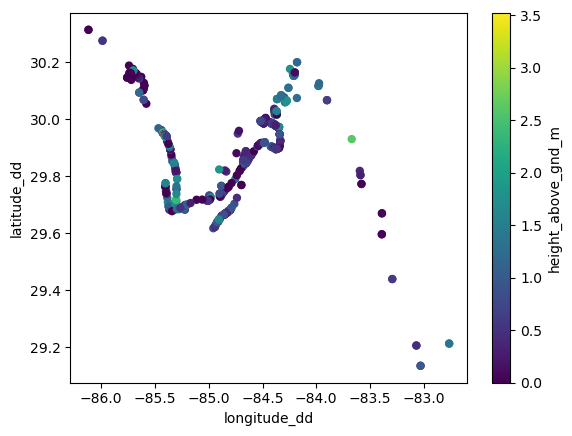

In [8]:
# Make a map of the height above ground of the high-water marks
df_hwm.plot.scatter(x='longitude_dd', y='latitude_dd', s = 25, c = 'height_above_gnd_m' )

-0.08822406 15.1


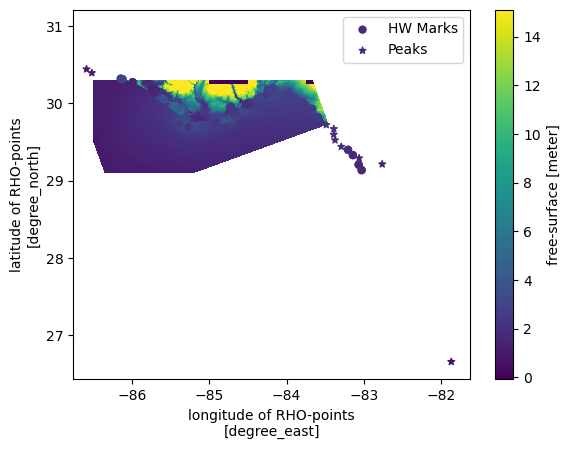

In [9]:
# Make a map with overlay of the high-water data on the 
vmin = zmax.min().values
vmax = zmax.max().values
print(vmin, vmax)
zmax.plot(x="lon_rho", y="lat_rho", vmin=vmin, vmax=vmax)
plt.scatter( df_hwm['longitude_dd'], df_hwm['latitude_dd'], s=25, c = df_hwm['elev_m'], \
            vmin=vmin, vmax=vmax, label='HW Marks' )
plt.scatter( df_peaks['longitude_dd'], df_peaks['latitude_dd'], s=25, c = df_peaks['peak_stage_m'], \
            vmin=vmin, vmax=vmax, marker = '*', label='Peaks' )
plt.legend()

In [10]:
# Loop through the high-water marks and find zmax in nearest model grid point
# This was glacially slow before I added the .compute() function while calculating zmax
meas_hwm = df_hwm['elev_m'].values
model_zeta_hwm = np.nan*np.ones_like( meas_hwm )
for i, (lonr, latr) in enumerate( zip(df_hwm['longitude_dd'].values, df_hwm['latitude_dd'].values) ):
    model_zeta_hwm[i] =  zmax.xroms.sel2d(lonr, latr).values

meas_peaks = df_peaks['peak_stage_m'].values
model_zeta_peaks = np.nan*np.ones_like( meas_peaks )
for i, (lonr, latr) in enumerate( zip(df_peaks['longitude_dd'].values, df_peaks['latitude_dd'].values) ):
    model_zeta_peaks[i] =  zmax.xroms.sel2d(lonr, latr).values

In [16]:
# These seem really small
hwm_err = df_hwm['uncertainty_m'].values
hwm_err[np.isnan(hwm_err)]=0.

array([ 0.003048 ,  0.003048 ,  0.003048 ,  0.003048 ,  0.01524  ,
        0.003048 ,  0.003048 ,  0.       ,  0.003048 ,  0.003048 ,
        0.024384 ,  0.018288 ,  0.018288 ,  0.024384 ,  0.003048 ,
        0.003048 ,  0.018288 ,  0.024384 ,  0.024384 ,  0.024384 ,
        0.003048 ,  0.018288 ,  0.018288 ,  0.018288 ,  0.018288 ,
        0.018288 ,  0.018288 ,  0.018288 ,  0.003048 ,  0.003048 ,
        0.018288 ,  0.003048 ,  0.003048 ,  0.0057912,  0.0057912,
        0.0054864,  0.0054864,  0.003048 ,  0.003048 ,  0.06096  ,
        0.06096  ,  0.003048 ,  0.003048 ,  0.03048  ,  0.03048  ,
        0.027432 ,  0.027432 ,  0.044196 ,  0.044196 ,  0.003048 ,
        0.039624 ,  0.0164592,  0.0164592,  0.003048 ,  0.0164592,
        0.0164592,  0.0164592,  0.003048 ,  0.003048 ,  0.009144 ,
        0.009144 ,  0.003048 ,  0.0164592,  0.       ,  0.       ,
        0.       ,  0.0164592,  0.0164592,  0.054864 ,  0.0070104,
        0.054864 ,  0.0070104,  0.0070104,  0.03048  ,  0.0304

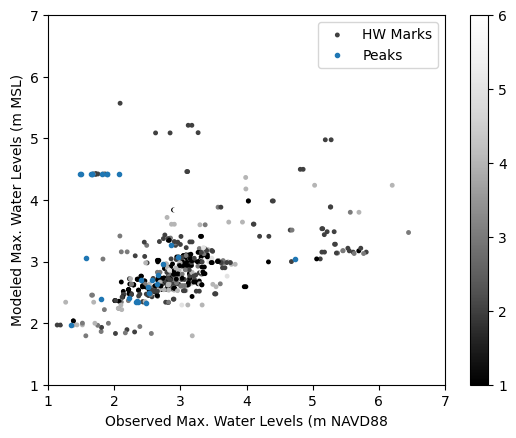

In [28]:
# tried to plot these with error bars, but they are so tiny they dont show up
plt.scatter(meas_hwm, model_zeta_hwm,25, df_hwm['hwm_quality_id'].values, '.', label = 'HW Marks', cmap ='Greys_r' )
plt.plot(meas_peaks, model_zeta_peaks, '.', label='Peaks')
plt.xlabel('Observed Max. Water Levels (m NAVD88')
plt.ylabel('Modeled Max. Water Levels (m MSL)')
plt.xlim([1,7])
plt.ylim([1,7])
plt.colorbar()
plt.legend()